# 04 - Configuration and Parameters

Understanding and tuning Segmenter parameters for optimal results.

## What You'll Learn
- Configuration parameters explained
- Built-in config presets
- Error metrics (ABSOLUTE vs RELATIVE)
- Creating custom configurations
- Visual comparison of different configs

## Setup

In [1]:
import warnings

import yfinance as yf

from trend_classifier import Segmenter
from trend_classifier.configuration import (
    CONFIG_ABS,
    CONFIG_REL,
    CONFIG_REL_SLOPE_ONLY,
    Config,
)
from trend_classifier.models import Metrics

warnings.filterwarnings("ignore")

# Download data
df = yf.download("AAPL", start="2018-09-15", end="2022-09-05", interval="1d", progress=False)
x = list(range(len(df)))
# Handle multi-index columns from yfinance
col = df["Close"]
y = col.squeeze().tolist() if hasattr(col, "squeeze") else col.tolist()

print(f"Data: {len(df)} points")

Data: 999 points


## Configuration Parameters

The `Config` class controls how segments are detected:

| Parameter | Description | Default |
|-----------|-------------|---------|
| `N` | Window size for trend calculation | 60 |
| `overlap_ratio` | Overlap between adjacent windows (0-1) | 0.33 |
| `alpha` | Threshold for slope change detection | 2 |
| `beta` | Threshold for offset change detection | 2 |
| `metrics_for_alpha` | Error metric for slope comparison | RELATIVE |
| `metrics_for_beta` | Error metric for offset comparison | RELATIVE |

In [2]:
# View default configuration
default_cfg = Config()
print("Default Config:")
print(f"  N (window size): {default_cfg.N}")
print(f"  overlap_ratio: {default_cfg.overlap_ratio}")
print(f"  alpha (slope threshold): {default_cfg.alpha}")
print(f"  beta (offset threshold): {default_cfg.beta}")
print(f"  metrics_for_alpha: {default_cfg.metrics_for_alpha}")
print(f"  metrics_for_beta: {default_cfg.metrics_for_beta}")

Default Config:
  N (window size): 60
  overlap_ratio: 0.33
  alpha (slope threshold): 2
  beta (offset threshold): 2
  metrics_for_alpha: Metrics.RELATIVE_ABSOLUTE_ERROR
  metrics_for_beta: Metrics.RELATIVE_ABSOLUTE_ERROR


## Parameter Effects

### Window Size (`N`)
- **Larger N** → Smoother trends, fewer segments, less sensitive to noise
- **Smaller N** → More segments, captures shorter trends, more sensitive

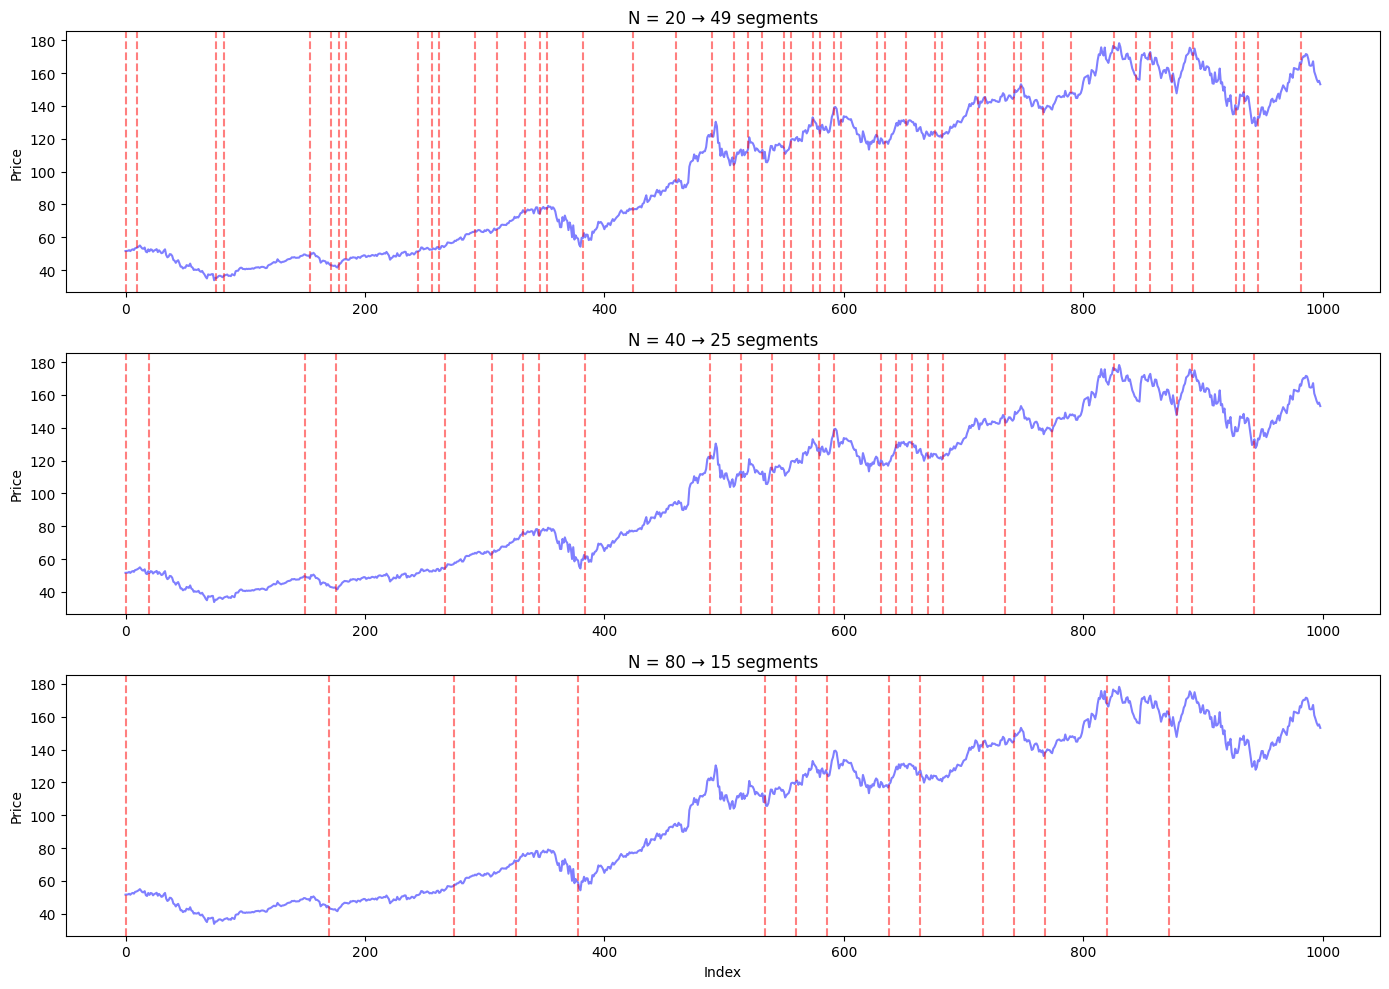

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for ax, n_val in zip(axes, [20, 40, 80]):
    seg = Segmenter(x=x, y=y, n=n_val)
    seg.calculate_segments()
    
    ax.plot(x, y, 'b-', alpha=0.5)
    for segment in seg.segments:
        ax.axvline(x=segment.start, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f"N = {n_val} → {len(seg.segments)} segments")
    ax.set_ylabel("Price")

axes[-1].set_xlabel("Index")
plt.tight_layout()
plt.show()

### Alpha and Beta Thresholds

- **Lower alpha/beta** → More sensitive to changes, more segments
- **Higher alpha/beta** → Less sensitive, fewer segments
- **alpha=None** → Ignore slope changes
- **beta=None** → Ignore offset changes

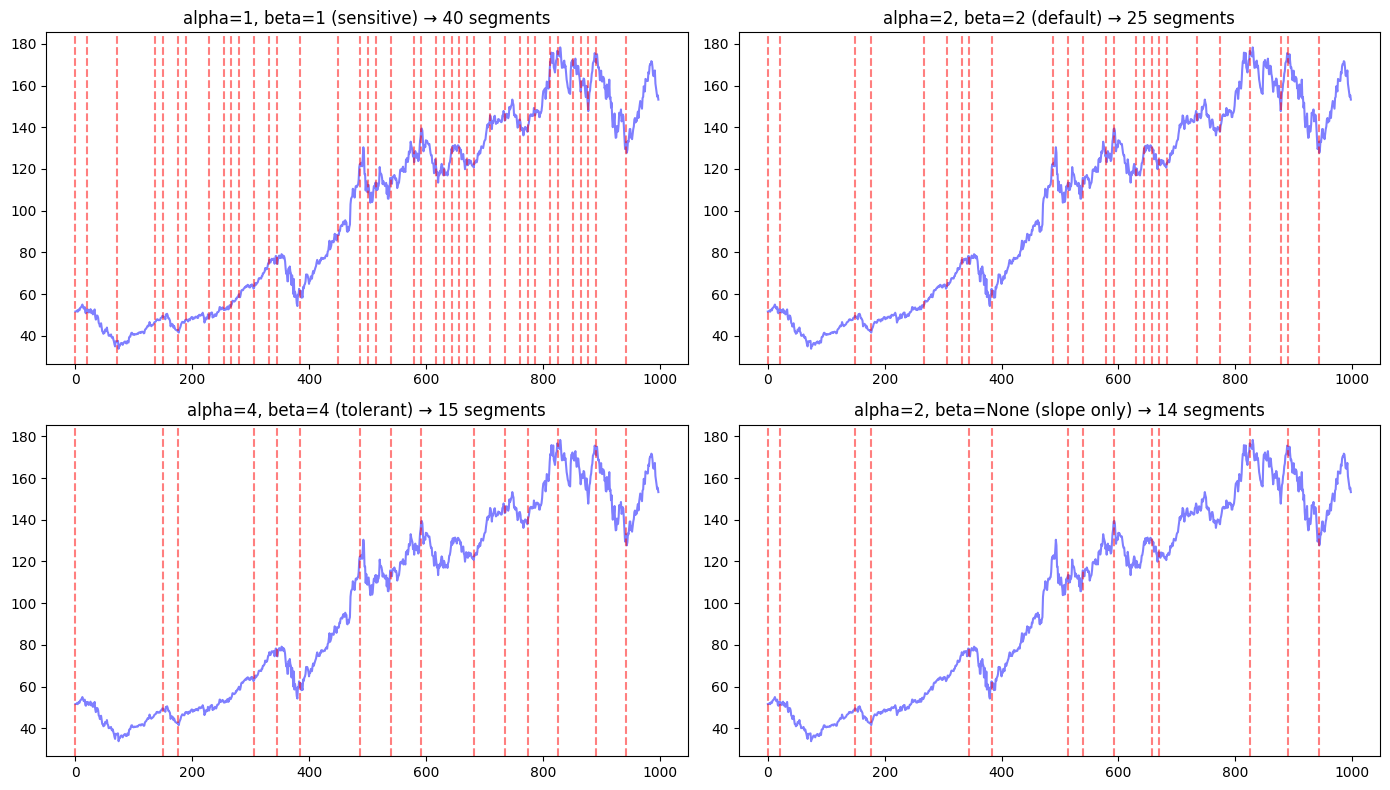

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

configs = [
    (Config(N=40, alpha=1, beta=1), "alpha=1, beta=1 (sensitive)"),
    (Config(N=40, alpha=2, beta=2), "alpha=2, beta=2 (default)"),
    (Config(N=40, alpha=4, beta=4), "alpha=4, beta=4 (tolerant)"),
    (Config(N=40, alpha=2, beta=None), "alpha=2, beta=None (slope only)"),
]

for ax, (cfg, title) in zip(axes.flat, configs):
    seg = Segmenter(x=x, y=y, config=cfg)
    seg.calculate_segments()
    
    ax.plot(x, y, 'b-', alpha=0.5)
    for segment in seg.segments:
        ax.axvline(x=segment.start, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f"{title} → {len(seg.segments)} segments")

plt.tight_layout()
plt.show()

## Built-in Config Presets

Three ready-to-use configurations are provided:

In [5]:
print("CONFIG_REL (Relative Error for both):")
print(f"  N={CONFIG_REL.N}, alpha={CONFIG_REL.alpha}, beta={CONFIG_REL.beta}")
print(f"  metrics: {CONFIG_REL.metrics_for_alpha.name}")

print("\nCONFIG_ABS (Absolute Error for alpha):")
print(f"  N={CONFIG_ABS.N}, alpha={CONFIG_ABS.alpha}, beta={CONFIG_ABS.beta}")
print(f"  alpha metric: {CONFIG_ABS.metrics_for_alpha.name}")
print(f"  beta metric: {CONFIG_ABS.metrics_for_beta.name}")

print("\nCONFIG_REL_SLOPE_ONLY (Ignore offset changes):")
print(f"  N={CONFIG_REL_SLOPE_ONLY.N}, alpha={CONFIG_REL_SLOPE_ONLY.alpha}, beta={CONFIG_REL_SLOPE_ONLY.beta}")

CONFIG_REL (Relative Error for both):
  N=40, alpha=2.0, beta=2.0
  metrics: RELATIVE_ABSOLUTE_ERROR

CONFIG_ABS (Absolute Error for alpha):
  N=40, alpha=100.0, beta=2.0
  alpha metric: ABSOLUTE_ERROR
  beta metric: RELATIVE_ABSOLUTE_ERROR

CONFIG_REL_SLOPE_ONLY (Ignore offset changes):
  N=40, alpha=2.0, beta=None


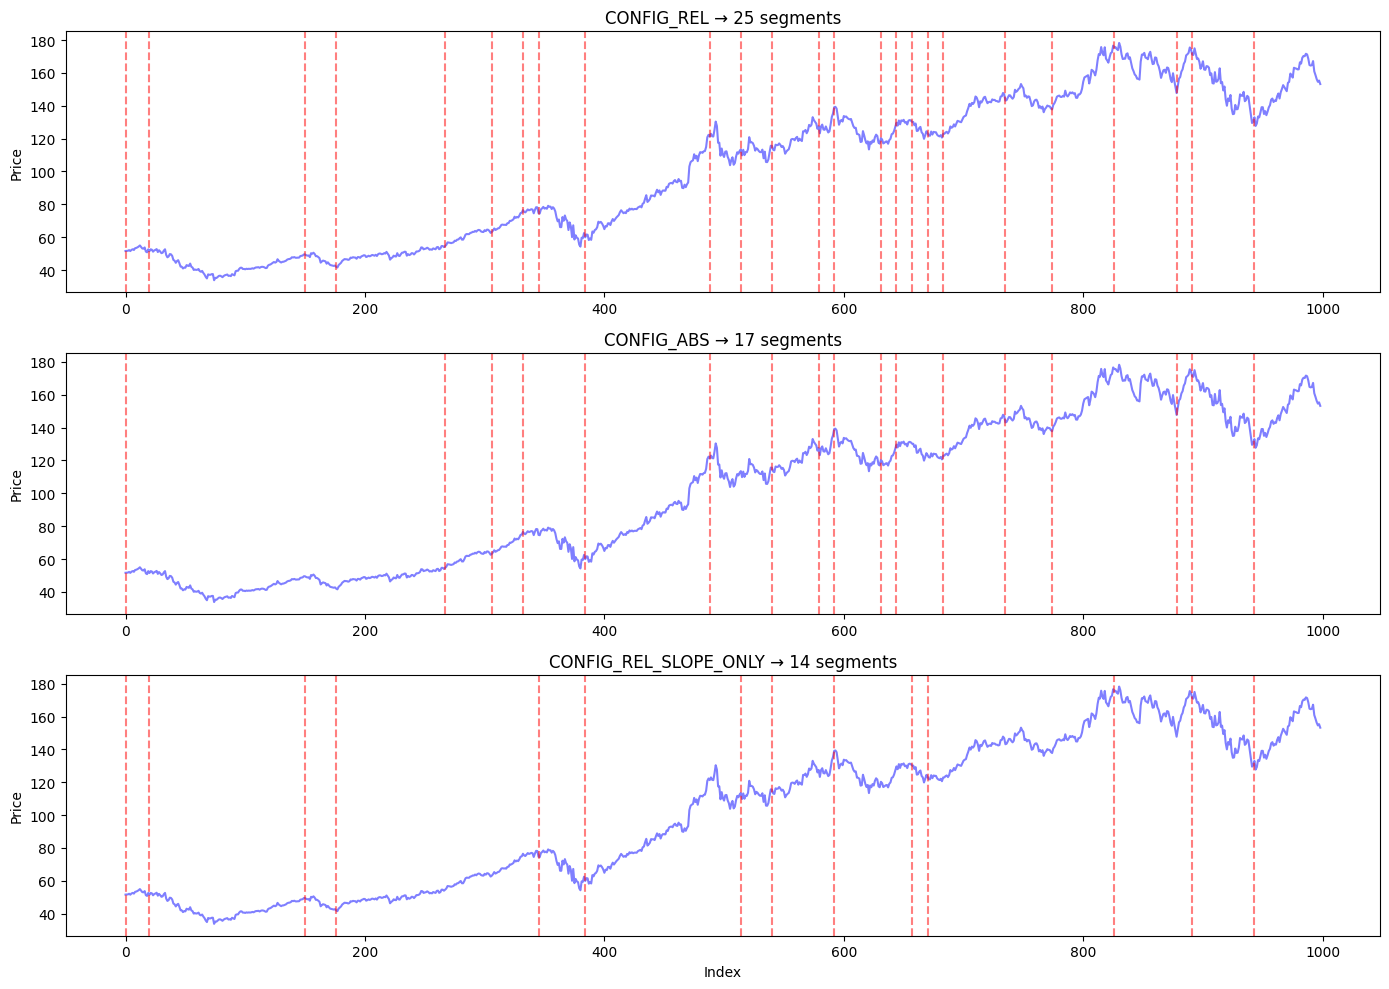

In [6]:
# Compare presets visually
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

presets = [
    (CONFIG_REL, "CONFIG_REL"),
    (CONFIG_ABS, "CONFIG_ABS"),
    (CONFIG_REL_SLOPE_ONLY, "CONFIG_REL_SLOPE_ONLY"),
]

for ax, (cfg, name) in zip(axes, presets):
    seg = Segmenter(x=x, y=y, config=cfg)
    seg.calculate_segments()
    
    ax.plot(x, y, 'b-', alpha=0.5)
    for segment in seg.segments:
        ax.axvline(x=segment.start, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f"{name} → {len(seg.segments)} segments")
    ax.set_ylabel("Price")

axes[-1].set_xlabel("Index")
plt.tight_layout()
plt.show()

## Error Metrics Explained

Two metrics are available for comparing slopes/offsets between windows:

### ABSOLUTE_ERROR
```
error = |a - b|
```
- Raw difference between values
- Good when values are in similar range

### RELATIVE_ABSOLUTE_ERROR  
```
error = |a - b| / |a|
```
- Percentage difference relative to first value
- Better for values that vary in scale (like prices)

In [7]:
# Demonstrate the difference
from trend_classifier.segmentation import calculate_error

# Two slopes being compared
slope1, slope2 = 0.5, 0.6

abs_error = calculate_error(slope1, slope2, Metrics.ABSOLUTE_ERROR)
rel_error = calculate_error(slope1, slope2, Metrics.RELATIVE_ABSOLUTE_ERROR)

print(f"Comparing slopes {slope1} and {slope2}:")
print(f"  Absolute Error: {abs_error}")
print(f"  Relative Absolute Error: {rel_error} ({rel_error*100:.0f}%)")

# With larger values
slope1, slope2 = 5.0, 5.1

abs_error = calculate_error(slope1, slope2, Metrics.ABSOLUTE_ERROR)
rel_error = calculate_error(slope1, slope2, Metrics.RELATIVE_ABSOLUTE_ERROR)

print(f"\nComparing slopes {slope1} and {slope2}:")
print(f"  Absolute Error: {abs_error}")
print(f"  Relative Absolute Error: {rel_error} ({rel_error*100:.0f}%)")

Comparing slopes 0.5 and 0.6:
  Absolute Error: 0.09999999999999998
  Relative Absolute Error: 0.19999999999999996 (20%)

Comparing slopes 5.0 and 5.1:
  Absolute Error: 0.09999999999999964
  Relative Absolute Error: 0.019999999999999928 (2%)


## Creating Custom Configurations

Custom config: 16 segments


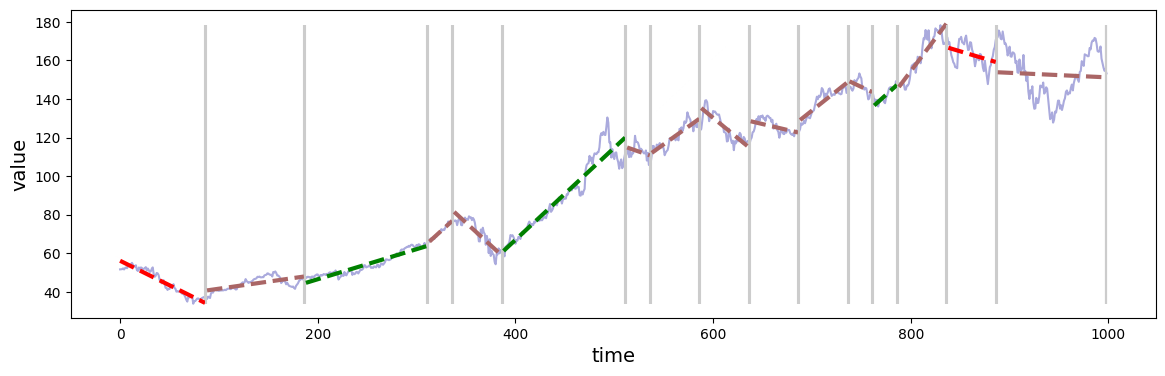

In [8]:
# Method 1: Modify a preset
custom_cfg = Config(
    N=50,
    overlap_ratio=0.5,  # More overlap = more granular
    alpha=1.5,          # More sensitive to slope changes
    beta=3,             # Less sensitive to offset changes
)

seg = Segmenter(x=x, y=y, config=custom_cfg)
seg.calculate_segments()
print(f"Custom config: {len(seg.segments)} segments")
seg.plot_segments(fig_size=(14, 4))

In [9]:
# Method 2: Start from preset and modify
cfg = Config(**CONFIG_REL.model_dump())
cfg.N = 30
cfg.alpha = 1.5

seg = Segmenter(x=x, y=y, config=cfg)
seg.calculate_segments()
print(f"Modified CONFIG_REL: {len(seg.segments)} segments")

Modified CONFIG_REL: 34 segments


## Guidelines for Parameter Selection

| Scenario | Recommended Settings |
|----------|---------------------|
| **Noisy data** | Larger N (60-100), higher alpha/beta |
| **Clean trends** | Smaller N (20-40), lower alpha/beta |
| **Short timeframe** | Smaller N, lower overlap_ratio |
| **Long timeframe** | Larger N, higher overlap_ratio |
| **Focus on direction** | Use CONFIG_REL_SLOPE_ONLY (beta=None) |
| **Volatile asset (crypto)** | Higher alpha/beta, larger N |
| **Stable asset (bonds)** | Lower alpha/beta, smaller N |

## Next Steps

- **05_classification.py** - Classify segments by trend type
- **06_advanced_optimization.py** - Automated parameter tuning with Optuna